In [1]:
import os
from scipy.io import loadmat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne
import funcs4anal as fa
import re

### Load data

In [2]:
# load raw
subject_id = 10
session = 1 # 1: before, 2: after
sessions = ['before', 'after']
before_or_after = sessions[session-1]
eeg_path = os.path.join('..', '..', '..','data', str(subject_id), 'repaired_' + before_or_after + '.fif')
eeg = mne.io.read_raw_fif(eeg_path, preload=True, verbose=False)
# raw.plot()
print(eeg.info['subject_info'],eeg.info['experimenter'])

C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_15948\3071393021.py:7: RuntimeWarning: This filename (..\..\..\data\10\repaired_before.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg = mne.io.read_raw_fif(eeg_path, preload=True, verbose=False)


{'id': 10} before


### Make default events

120 events found
Event IDs: [1]
120 events found
Event IDs: [1]
30 events found
Event IDs: [1]
30 events found
Event IDs: [1]
30 events found
Event IDs: [1]
30 events found
Event IDs: [1]
96 events found
Event IDs: [1]
24 events found
Event IDs: [1]
60 events found
Event IDs: [1]
60 events found
Event IDs: [1]
120 events found
Event IDs: [1]
60 events found
Event IDs: [1]
60 events found
Event IDs: [1]
40 events found
Event IDs: [1]
48 events found
Event IDs: [1]
32 events found
Event IDs: [1]
32 events found
Event IDs: [1]
24 events found
Event IDs: [1]
8 events found
Event IDs: [1]
24 events found
Event IDs: [1]
32 events found
Event IDs: [1]
113 events found
Event IDs: [1]


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_15948\945369280.py:19: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=eeg.info['sfreq'],


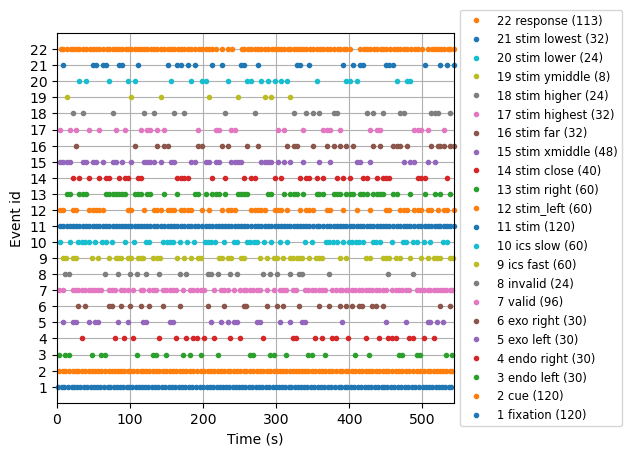

In [3]:
# Extract channel names and types
ch_names = eeg.info['ch_names']
ch_types = ['misc'] + ['eeg'] * 32 + ['misc'] + ['stim'] * 22

# Detect events
stim_channel_names = [ch_name for ch_name, ch_type in zip(ch_names, ch_types) if ch_type == 'stim']
events = np.array([], dtype=int).reshape(0, 3)  # Create an empty events array with 3 columns

for idx, stim_channel_name in enumerate(stim_channel_names):
    single_event = mne.find_events(eeg, stim_channel=stim_channel_name, min_duration=1/eeg.info['sfreq'])

    # Update the event id in single_event (the third column) to be idx + 1
    single_event[:, 2] = idx + 1

    # Concatenate single_event to the events array
    events = np.vstack([events, single_event])

event_dict = {str(idx+1)+" "+stim_channel_name: idx + 1 for idx, stim_channel_name in enumerate(stim_channel_names)}
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=eeg.info['sfreq'],
                          first_samp=eeg.first_samp)


### Customize events

the_pieces: 48
picked_events: 478


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_15948\1040621223.py:30: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(picked_events, event_id=picked_events_dict, sfreq=eeg.info['sfreq'], first_samp=eeg.first_samp)


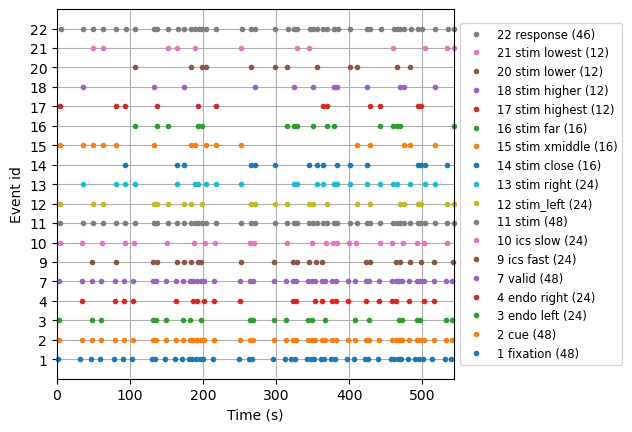

In [4]:
# Get the indices that would sort the first column
sort_indices = np.argsort(events[:, 0])

# Use these indices to sort the entire array
sorted_events = events[sort_indices]

# Make pieces
pieces = []
piece = []
for event in sorted_events:
    if event[2] == 1 and piece:  # Found a 1 in the third column and there are events in current piece
        pieces.append(np.array(piece))  # Save the current piece as a numpy array
        piece = []  # Create a new piece
    piece.append(event)  # Add the current event to the piece

# Add the last piece if it's not empty
if piece:
    pieces.append(np.array(piece))

# e.g. (3 OR 4) AND 7
# the_pieces = [piece for piece in pieces if (any(piece[:, 2] == 3) | any(piece[:, 2] == 4)) & any(piece[:, 2] == 7)]

the_pieces = eval(fa.condition("(3 | 4) & 7"))
picked_events = np.vstack(the_pieces)
picked_events_dict = {key: value for key, value in event_dict.items() if value in picked_events[:, 2]}

print("the_pieces:", len(the_pieces))
print("picked_events:", len(picked_events))

fig = mne.viz.plot_events(picked_events, event_id=picked_events_dict, sfreq=eeg.info['sfreq'], first_samp=eeg.first_samp)


### make epochs

Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2401 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


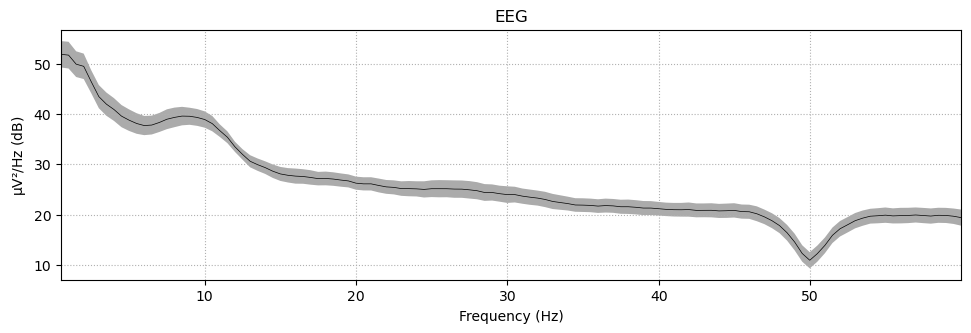

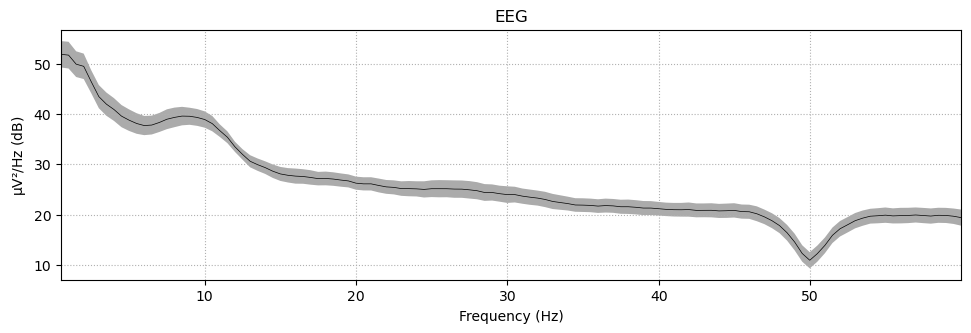

In [ ]:
# Create epochs with the interested events

epochs = mne.Epochs(eeg, picked_events, event_id=picked_events_dict['2 cue'], tmin = -0.5, tmax=1.5, baseline=(0,0), preload=True)
epochs.plot_psd(fmin=0.1, fmax=60, average=True)

# Plot the epochs
# epochs.plot_image(picks=['Cz', 'P6'])

No baseline correction applied


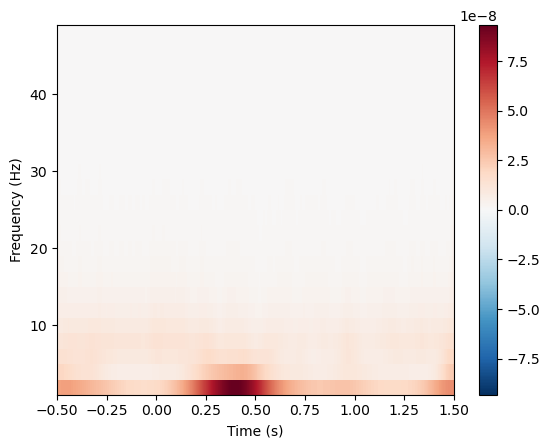

[<Figure size 640x480 with 2 Axes>]

In [ ]:
frequencies = np.arange(2, 50, 2)
power = mne.time_frequency.tfr_morlet(
    epochs, n_cycles=2, return_itc=False, freqs=frequencies, decim=3
)
power.plot(["Cz"])